# Free rolling tyre analysis

First, we'll import an example TIR file. We can do this by calling `Tyre(<filename>)`. This will read the selected TIR file, validate the parameters, and create a tyre instance. Each model type has its own class, and this is automatically selected depending on the `FITTYP` parameter. To override this, add `model_type=<model>` as an argument, where `<model>` can be any of the recent magic formula types (provided they are older than the `FITTYP` version). Multiple variations (e.g. `MF52`, `MF 5.2` or simply `52`) are valid inputs. Overriding the model type is only possible with MF 5.2 onwards, as the older versions are not backwards compatible.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.utils.initialize_tyre import Tyre

# load tyre
tyre = Tyre(
    'car205_60R19.tir',
    validate=True,
    use_alpha_star=False,
    check_format=False,
    check_limits=False)

TIR file 'car205_60R19.tir' successfully loaded.
Validation of TIR file successful. All parameters found for version MF6.2
Tyre instance of type <class 'src.models.magic_formula_61.MF61'> successfully created.


We can find commonly used outputs for free rolling vehicle models with the `find_lateral_output()` function.
To do this, we'll need to specify the following inputs:
1. `SA` - slip angle
2. `FZ` - vertical load on the tyre
3. `N` - angular speed of the wheel

Additionally, a few optional arguments can be passed as well:
1. `P` - tyre pressure (is set to the nominal pressure if not specified)
2. `IA` - inclination angle with respect to the ground plane (is set to zero if not specified)
2. `VC` - contact patch speed (is set to the nominal speed if not specified)
2. `VCX` - longitudinal contact patch speed (only used to account for reverse running, set to one if not specified)
3. `VS` - contact patch slip speed (is used for speed correction, set to the nominal speed if not specified)

Input channels that represent an angle can be specified in either radians or degrees. Radians is the default setting. `angle_unit = "deg"` will have to be passed as well if your input signals are in degrees.

This function returns a list with the following outputs:
1. `FY` - lateral force
2. `MX` - overturning couple
3. `MZ` - self-aligning couple
4. `RL` - loaded tyre radius
5. `sigma_y` - lateral relaxation length

All of the above outputs are calculated for pure lateral slip conditions.

lateral relaxation length: -0.338 m


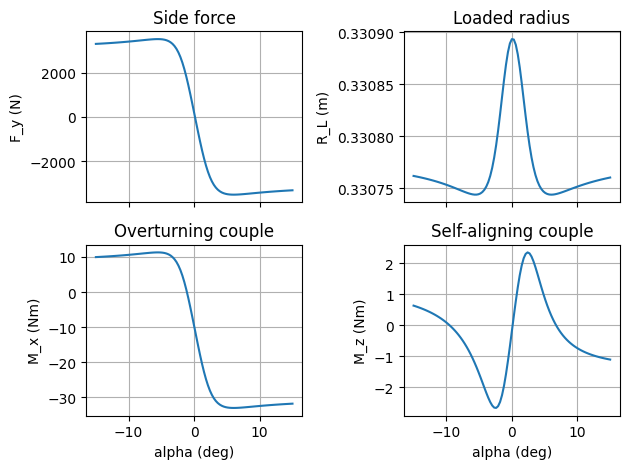

In [27]:
# set the speed for the analysis
VC = 100/3.6 # m/s

# we can extract the tyre properties as follows
R0 = tyre.UNLOADED_RADIUS

# for simplicity, we'll assume the rpm of the wheel is defined by the unloaded radius
N = VC / R0

# slip angle sweep (in degrees) for constant load
SA = np.linspace(-15, 15, 101)
FZ = tyre.FNOMIN

# we find the outputs by appending our function to the tyre instance
[FY, MX, MZ, RL, sigma_y] = tyre.find_lateral_output(SA=SA, FZ=FZ, N=N, VC=VC, angle_unit="deg")

# plot results
print(f"lateral relaxation length: {sigma_y:.3f} m")
fig, axs = plt.subplots(2,2, sharex=True)
axs[0,0].plot(SA, FY)
axs[0,0].set(ylabel='F_y (N)', title='Side force')
axs[0,0].grid()
axs[0,1].plot(SA, RL)
axs[0,1].set(ylabel='R_L (m)', title='Loaded radius')
axs[0,1].grid()
axs[1,0].plot(SA, MX)
axs[1,0].set(xlabel='alpha (deg)', ylabel='M_x (Nm)', title='Overturning couple')
axs[1,0].grid()
axs[1,1].plot(SA, MZ)
axs[1,1].set(xlabel='alpha (deg)', ylabel='M_z (Nm)', title='Self-aligning couple')
axs[1,1].grid()
plt.tight_layout()
plt.show()

As you can see in the above graphs, the standard output format for most TIR files gives a negative force for a positive slip angle, consistent with ISO 8855:2011. A lot of vehicle dynamics models use an alternative convention where positive slip leads to a positive force. To use this convention instead, add `iso_alt=True` as an argument when you initialize the tyre.

Next, let's see the effect of adding some camber. `find_lateral_output()` is a collection of multiple smaller functions, which we can also call separately, so let's do that instead.

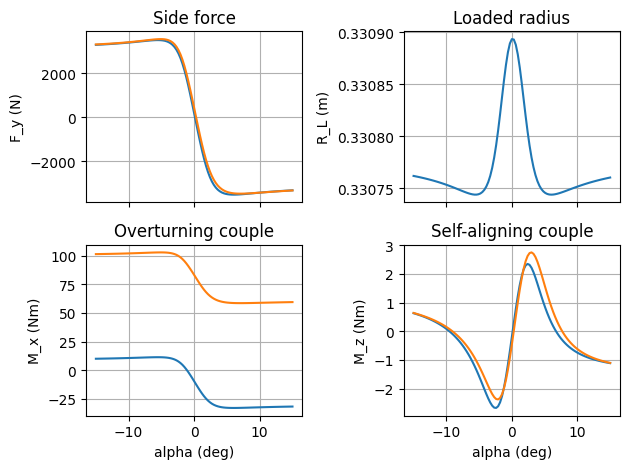

In [30]:
# inclination angle (degrees)
IA = -4.0

# these functions are equivalent to calling `find_lateral_output()`
FY2 = tyre.find_fy_pure(SA=SA, FZ=FZ, IA=IA, angle_unit="deg")
MX2 = tyre.find_mx_pure(SA=SA, FZ=FZ, IA=IA, angle_unit="deg")
MZ2 = tyre.find_mz_pure(SA=SA, FZ=FZ, IA=IA, VC=VC, angle_unit="deg")

# plot results
fig, axs = plt.subplots(2,2, sharex=True)
axs[0,0].plot(SA, FY), axs[0,0].plot(SA, FY2)
axs[0,0].set(ylabel='F_y (N)', title='Side force')
axs[0,0].grid()
axs[0,1].plot(SA, RL)
axs[0,1].set(ylabel='R_L (m)', title='Loaded radius')
axs[0,1].grid()
axs[1,0].plot(SA, MX), axs[1,0].plot(SA, MX2)
axs[1,0].set(xlabel='alpha (deg)', ylabel='M_x (Nm)', title='Overturning couple')
axs[1,0].grid()
axs[1,1].plot(SA, MZ), axs[1,1].plot(SA, MZ2)
axs[1,1].set(xlabel='alpha (deg)', ylabel='M_z (Nm)', title='Self-aligning couple')
axs[1,1].grid()
plt.tight_layout()
plt.show()